In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [2]:
import pickle
filename = 'C:\\Users\\Eliaz\\Documents\\GitHub\\Animal-identification-NN\\dataset\\raw-img\\datasetHSV.pkl'
df = pickle.load(open(filename, 'rb'))

In [51]:
working_df = df.copy()
working_df = working_df[np.isin(working_df['label'], ['cat', 'dog'])]
print(working_df['label'].value_counts())

dog    4863
cat    1668
Name: label, dtype: int64


In [52]:
print(working_df.columns)

Index(['label', 'img_hsv'], dtype='object')


In [53]:
#resize
size=80
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.resize(x, (size, size)))
print(working_df['img_hsv'].apply(lambda x: x.shape).unique().shape)

(1,)


In [54]:
#hsv to gray
# working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_HSV2RGB))
# working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY))

In [55]:
#img to array
print(working_df['img_hsv'].shape)
print(working_df['img_hsv'].iloc[0].shape)
print(type(working_df['img_hsv']))
print(type(working_df['img_hsv'].iloc[0]))
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: x.reshape(size, size, 3))
X = working_df['img_hsv'].values
X = np.stack(X)
print(X.shape)

(6531,)
(80, 80, 3)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(6531, 80, 80, 3)


In [56]:
#transforme le texte des labels en chiffres
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
working_df['label'] = le.fit_transform(working_df['label']) # 0 cat, 1 dog
print(working_df['label'].value_counts())

1    4863
0    1668
Name: label, dtype: int64


In [57]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, working_df['label'], test_size=0.2)


In [58]:
from tensorflow.keras.utils import to_categorical
num = 2
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)
print('turns',y_train.iloc[num],'into', train_Y_one_hot[num])

turns 1 into [0. 1.]


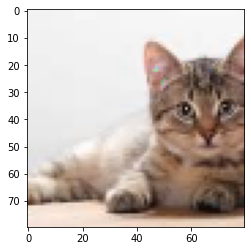

In [59]:
#impression image 
img = X[num]
rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
plt.imshow(rgb)

In [60]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [61]:
num_classes = train_Y_one_hot.shape[1]
print(num_classes)

2


In [62]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(size,size,X.shape[3])))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='linear'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
#couche de sortie
model.add(Dense(num_classes, activation='softmax'))

In [63]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 20736)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [66]:
model.fit(X_train, train_Y_one_hot, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, test_Y_one_hot))

Epoch 1/10
41/41 [==============================] - 24s 592ms/step - loss: 80.2604 - accuracy: 0.6598 - val_loss: 30.2073 - val_accuracy: 0.6098
Epoch 2/10
41/41 [==============================] - 24s 583ms/step - loss: 16.8724 - accuracy: 0.7330 - val_loss: 17.4238 - val_accuracy: 0.7391
Epoch 3/10
41/41 [==============================] - 24s 589ms/step - loss: 9.5165 - accuracy: 0.7801 - val_loss: 13.5977 - val_accuracy: 0.7169
Epoch 4/10
41/41 [==============================] - 24s 588ms/step - loss: 7.4150 - accuracy: 0.7956 - val_loss: 10.0560 - val_accuracy: 0.7184
Epoch 5/10
41/41 [==============================] - 22s 535ms/step - loss: 3.1099 - accuracy: 0.8595 - val_loss: 9.0816 - val_accuracy: 0.7200
Epoch 6/10
41/41 [==============================] - 23s 573ms/step - loss: 1.6982 - accuracy: 0.8918 - val_loss: 8.2304 - val_accuracy: 0.7360
Epoch 7/10
41/41 [==============================] - 23s 572ms/step - loss: 1.1070 - accuracy: 0.9154 - val_loss: 7.8056 - val_accuracy: 

In [67]:
eval = model.evaluate(X_test, test_Y_one_hot, verbose=1)

41/41 [==============================] - 2s 44ms/step - loss: 8.8547 - accuracy: 0.7184
